# How stress affects Sleep ?

## Dataset Overview:

**Sleep Health and Lifestyle Dataset**

**Key Dataset Columns:**

1. Quality of Sleep (scale: 1-10): A subjective rating of the quality of sleep, ranging from 1 to 10.
2. Physical Activity Level (minutes/day): The number of minutes the person engages in physical activity daily.
3. Stress Level (scale: 1-10): A subjective rating of the stress level experienced by the person, ranging from 1 to 10.
4. BMI Category: The BMI category of the person (Underweight, Normal, Overweight).
5. Blood Pressure (systolic/diastolic): The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure.
6. Heart Rate (bpm): The resting heart rate of the person in beats per minute.
7. Daily Steps: The number of steps the person takes per day.
8. Sleep Disorder: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).

**Details about Sleep Disorder Column:**

- None: The individual does not exhibit any specific sleep disorder.
- Insomnia: The individual experiences difficulty falling asleep or staying asleep.
- Sleep Apnea: The individual suffers from pauses in breathing during sleep.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import t, norm
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Person ID,374.0,187.500000,108.108742,1.0,94.25,187.5,280.75,374.0
Age,374.0,42.184492,8.673133,27.0,35.25,43.0,50.00,59.0
Sleep Duration,374.0,7.132086,0.795657,5.8,6.40,7.2,7.80,8.5
Quality of Sleep,374.0,7.312834,1.196956,4.0,6.00,7.0,8.00,9.0
Physical Activity Level,374.0,59.171123,20.830804,30.0,45.00,60.0,75.00,90.0
Stress Level,374.0,5.385027,1.774526,3.0,4.00,5.0,7.00,8.0
Heart Rate,374.0,70.165775,4.135676,65.0,68.00,70.0,72.00,86.0
Daily Steps,374.0,6816.844920,1617.915679,3000.0,5600.00,7000.0,8000.00,10000.0


In [ ]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## Data preprocessing


Let's check null values

> Which commands give the count of missing values per column vs per row?
> Which one is useful ?

In [ ]:
df.isnull().sum(axis=0)
# VS
# df.isnull().sum(axis=1)

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


Let's check what's happening in Sleep disorder column

In [ ]:
df['Sleep Disorder'].unique()

array([nan, 'Sleep Apnea', 'Insomnia'], dtype=object)

In [ ]:
df['Sleep Disorder'].fillna('None', inplace=True)
print(df['Sleep Disorder'].unique())

['None' 'Sleep Apnea' 'Insomnia']


In [ ]:
# dropping unuseful column
df.drop('Person ID',axis=1,inplace=True)

In [ ]:
# rename them for easier to use
df.columns = ['gender', 'age', 'occupation', 'sleep_dur', 'sleep_q', 'phys_act','stress', 'bmi', 'bld_pressure', 'hr', 'steps', 'sleep_dis']

After having a look at the blood pressure column,we find it is unsuitable as numeric values

In [ ]:
df['bld_pressure'].head()

,bld_pressure
0,126/83
1,125/80
2,125/80
3,140/90
4,140/90


We split it into 2 columns: High & Low Blood pressure

In [ ]:
df = pd.concat([df, df['bld_pressure'].str.split('/', expand=True)], axis=1).drop(
    'bld_pressure', axis=1)

df=df.rename(columns={0: 'pressure_h', 1: 'pressure_l'})
df['pressure_h'] = df['pressure_h'].astype(float)
df['pressure_l'] = df['pressure_l'].astype(float)

In [ ]:
print(df['pressure_h'].head())
print(df['pressure_l'].head())

0    126.0
1    125.0
2    125.0
3    140.0
4    140.0
Name: pressure_h, dtype: float64
0    83.0
1    80.0
2    80.0
3    90.0
4    90.0
Name: pressure_l, dtype: float64


## Visualization 1: Correlation matrix

In [ ]:
df.corr(numeric_only=True)

,age,sleep_dur,sleep_q,phys_act,stress,hr,steps,pressure_h,pressure_l
age,1.000000,0.344709,0.473734,0.178993,-0.422344,-0.225606,0.057973,0.605878,0.593839
sleep_dur,0.344709,1.000000,0.883213,0.212360,-0.811023,-0.516455,-0.039533,-0.180406,-0.166570
sleep_q,0.473734,0.883213,1.000000,0.192896,-0.898752,-0.659865,0.016791,-0.121632,-0.110151
phys_act,0.178993,0.212360,0.192896,1.000000,-0.034134,0.136971,0.772723,0.265416,0.382651
stress,-0.422344,-0.811023,-0.898752,-0.034134,1.000000,0.670026,0.186829,0.102818,0.091811
hr,-0.225606,-0.516455,-0.659865,0.136971,0.670026,1.000000,-0.030309,0.294143,0.271092
steps,0.057973,-0.039533,0.016791,0.772723,0.186829,-0.030309,1.000000,0.103342,0.241986
pressure_h,0.605878,-0.180406,-0.121632,0.265416,0.102818,0.294143,0.103342,1.000000,0.972885
pressure_l,0.593839,-0.166570,-0.110151,0.382651,0.091811,0.271092,0.241986,0.972885,1.000000


> Why do we need the line:
mask[np.tril_indices_from(mask)] = False


> Why do we need hiding some part of the matrix?

<Axes: >

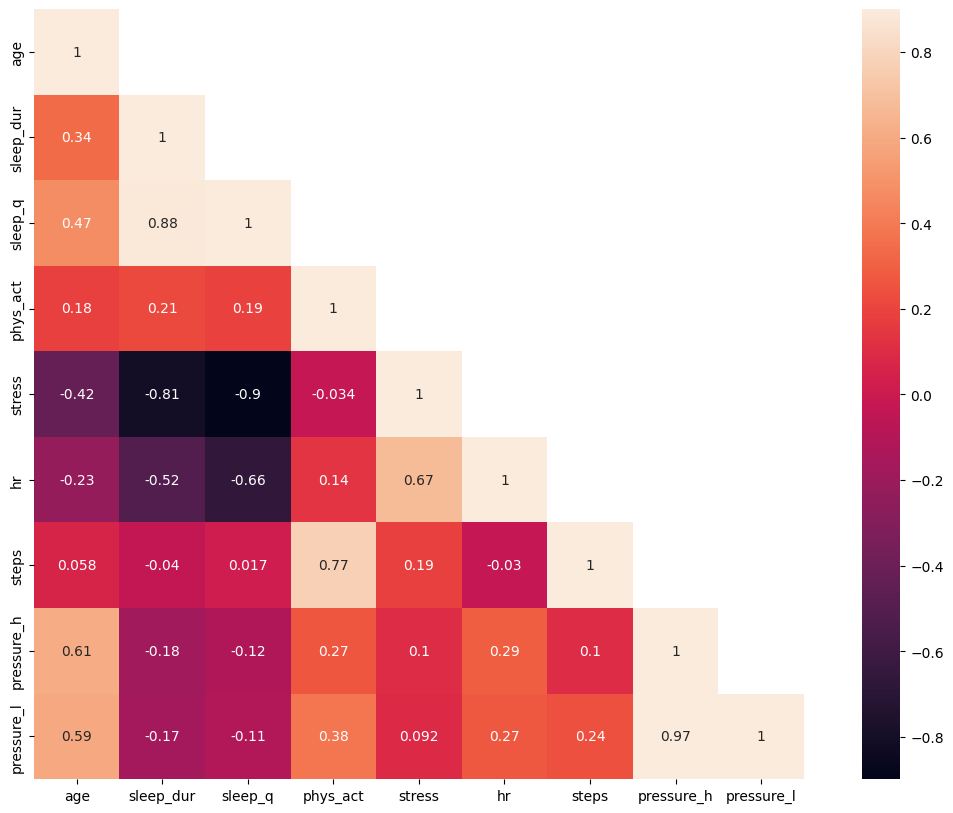

In [ ]:
# Pearson correlation matrix

corr = df.corr(method = 'pearson', numeric_only=True)
mask = np.array(corr)

mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(corr, mask = mask, vmax = 0.9, square = True, annot = True)

**Questions**
1. Which quantity does stress affect the most ?

2. **“Does age seem to affect sleep quality or stress more?”**

3. **“Is there any variable pair that seems independent ?”**

4. What two variables have an almost perfect positive correlation?

## Visualization 2: Scatterplot matrix

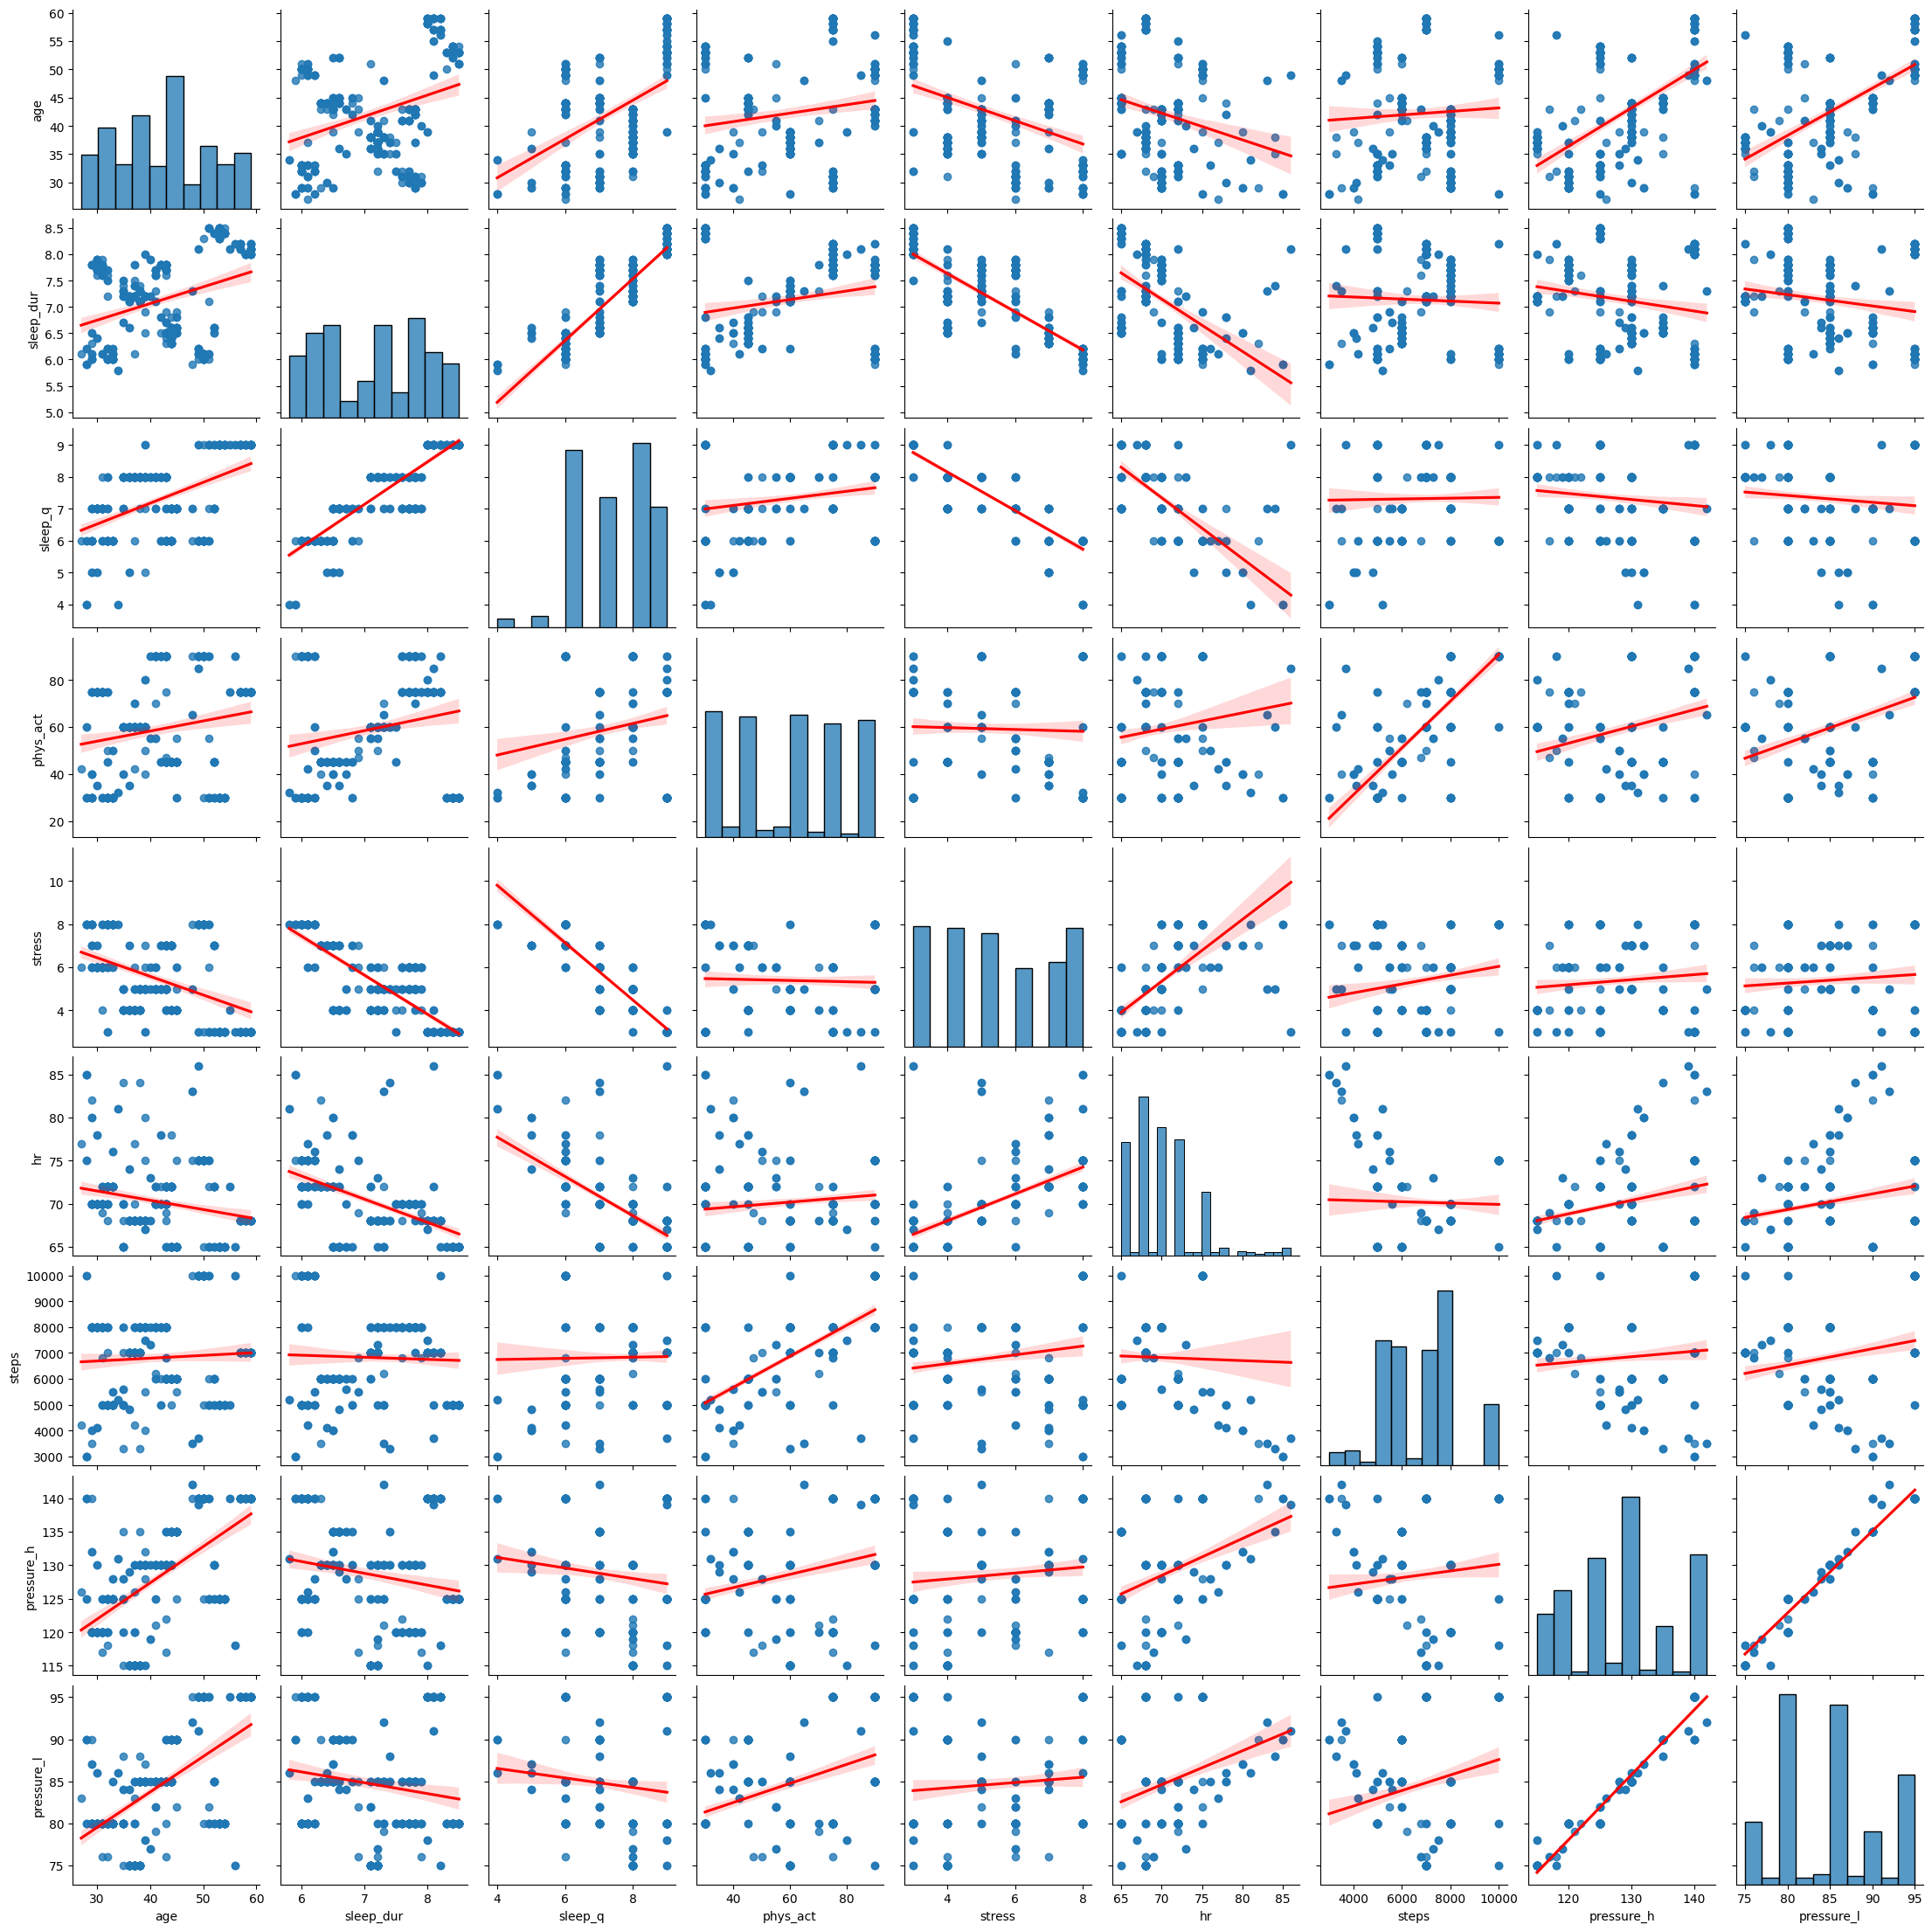

In [ ]:
# let's take closer look making linear regression matrix for each value

sns.pairplot(df, kind='reg', plot_kws={'line_kws': {'color': 'red'}})

Spot:
1. Stress vs sleep-quality
2. Sleep quality vs Heart rate

## Visualization 3: Population distribution

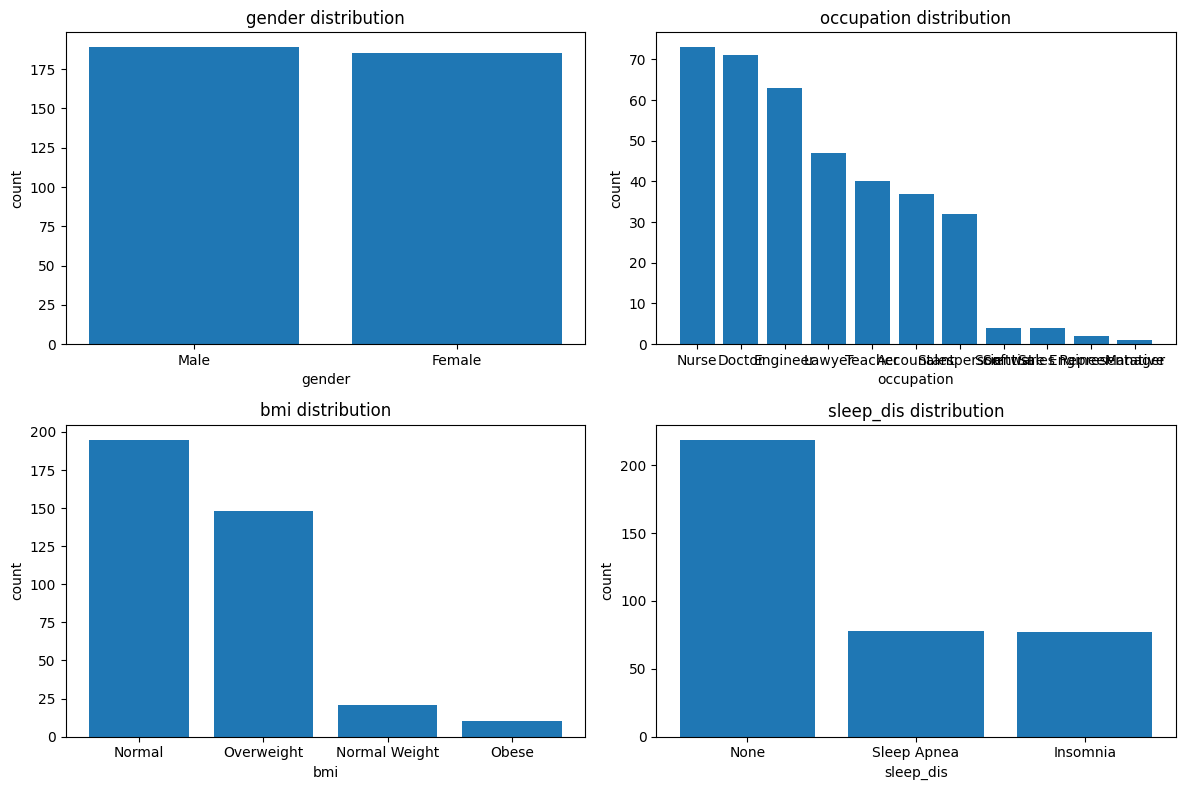

In [ ]:
# Categories of interviewed people

categories = ['gender', 'occupation', 'bmi', 'sleep_dis']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2

    counts = df[category].value_counts()

    axes[row, col].bar(counts.index, counts)
    axes[row, col].set_title(f'{category} distribution')
    axes[row, col].set_xlabel(category)
    axes[row, col].set_ylabel('count')

plt.tight_layout()
plt.show()


> Have a look at x axis in occupation plot. It looks horrible due to jumbled up labels, so one trick is to rotate the labels by some angle.

> Does anyone know the function we could use ?


Key:

* Significant amount of interviewed have overweight
* Third of the interviewed have trouble or lack of sleep

## Visualization 4: Histogram

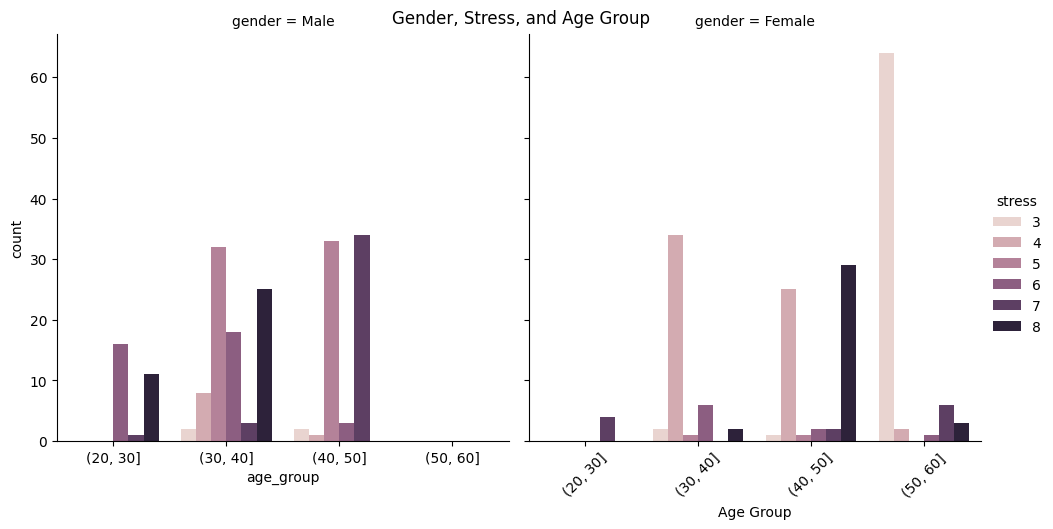

In [ ]:
age_groups = [20, 30, 40, 50, 60]
df['age_group'] = pd.cut(df['age'], bins=age_groups)

sns.catplot(data=df, x='age_group', hue='stress', col='gender', kind='count')

plt.xlabel('Age Group')
plt.ylabel('Count')
plt.suptitle('Gender, Stress, and Age Group')
plt.xticks(rotation=45)
plt.show()

1. Men in their 20s and 30s feel a lot of stress.
2. Women experience high stress much later, in their 40s.

## Visualization 5: Box plot

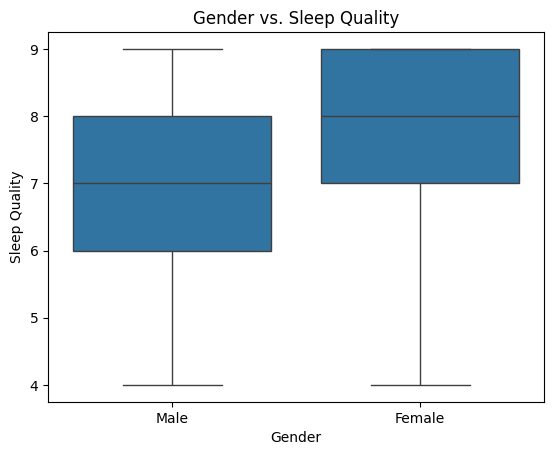

In [ ]:
# Starting with quality of sleep

sns.boxplot(data=df, x='gender', y='sleep_q')

plt.xlabel('Gender')
plt.ylabel('Sleep Quality')
plt.title('Gender vs. Sleep Quality')

plt.show()

Key:

Females have better sleep quality than males, which could be reason why women are less stressed

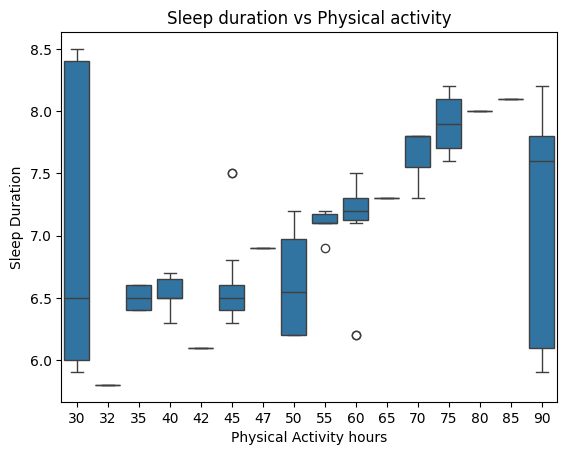

In [ ]:
sns.boxplot(data=df, x='phys_act', y='sleep_dur')

plt.xlabel('Physical Activity hours')
plt.ylabel('Sleep Duration')
plt.title('Sleep duration vs Physical activity')

plt.show()

<Axes: xlabel='stress', ylabel='sleep_dur'>

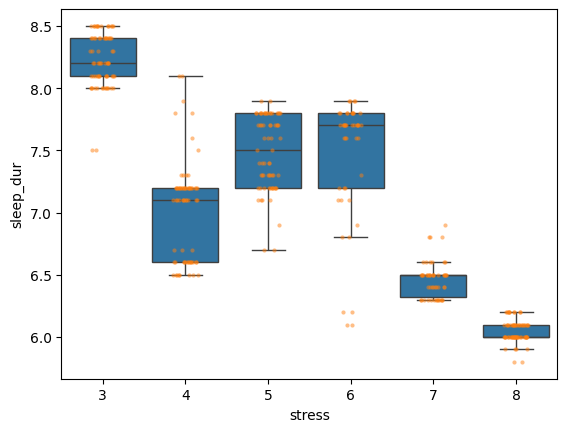

In [ ]:
ax = sns.boxplot(data=df, x="stress", y="sleep_dur", showfliers=False)
sns.stripplot(data=df, x="stress", y="sleep_dur", alpha=0.5, size=3, jitter=0.15)


> Stress only comes in discrete values then why do we have values around the discrete stress interval also ?

Hint: Look at the stripplot command

## Visualization 6: Stacked plots
Let's see effect of occupation in contributing to the stress

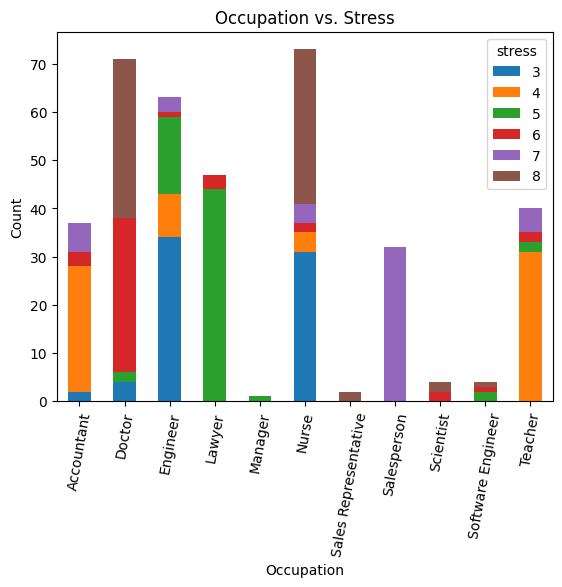

In [ ]:
# Look closely to stress level by profession

occupation_stress = pd.crosstab(df['occupation'], df['stress'])
occupation_stress.plot(kind='bar', stacked=True)

plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Occupation vs. Stress')

plt.xticks(rotation=80)
plt.show()

Key:

* Doctors, Salespersons, Scientists and Sales Representatives feel more stressed
* Nurses divided by 2 experience: their job very stressful or not stressful at all
* Lawyers are somewhere in the middle. Their job is not that intense
* Teachers and Accountants and Engineers are feel less stressful

# Visualization 7: Simpson's paradox

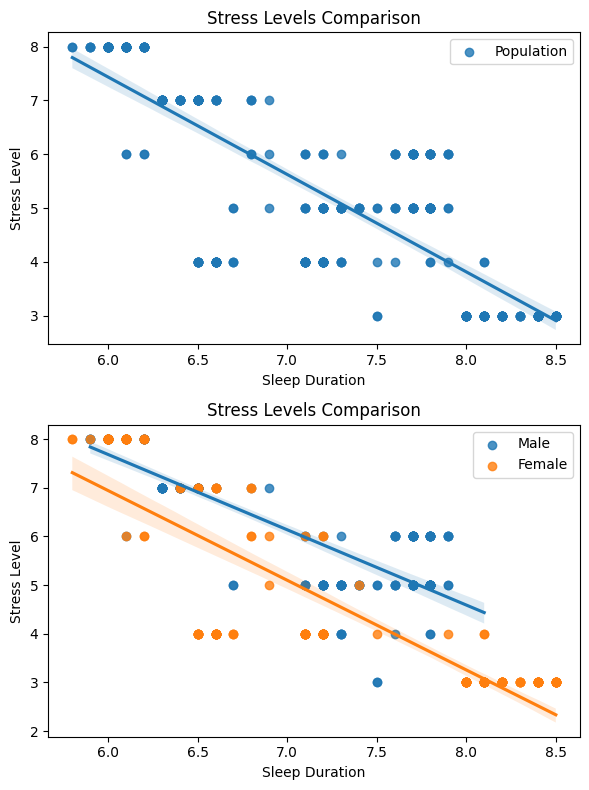

In [ ]:
# Let's divide respondents based on gender & see sleep_duration and stress level trend.

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

sns.regplot(data=df, x='sleep_dur', y='stress', ax=axs[0], label='Population')
axs[0].set_xlabel('Sleep Duration')
axs[0].set_ylabel('Stress Level')
axs[0].set_title('Stress Levels Comparison')
axs[0].legend()

sns.regplot(data=df[df['gender'] == 'Male'], x='sleep_dur', y='stress', ax=axs[1], label='Male')
sns.regplot(data=df[df['gender'] == 'Female'], x='sleep_dur', y='stress', ax=axs[1], label='Female')
axs[1].set_xlabel('Sleep Duration')
axs[1].set_ylabel('Stress Level')
axs[1].set_title('Stress Levels Comparison')
axs[1].legend()

plt.tight_layout()
plt.show()


Simpson’s paradox is when the overall (aggregated) relationship between two variables reverses or weakens after you split the data by a third variable (a “lurking”/confounding variable).

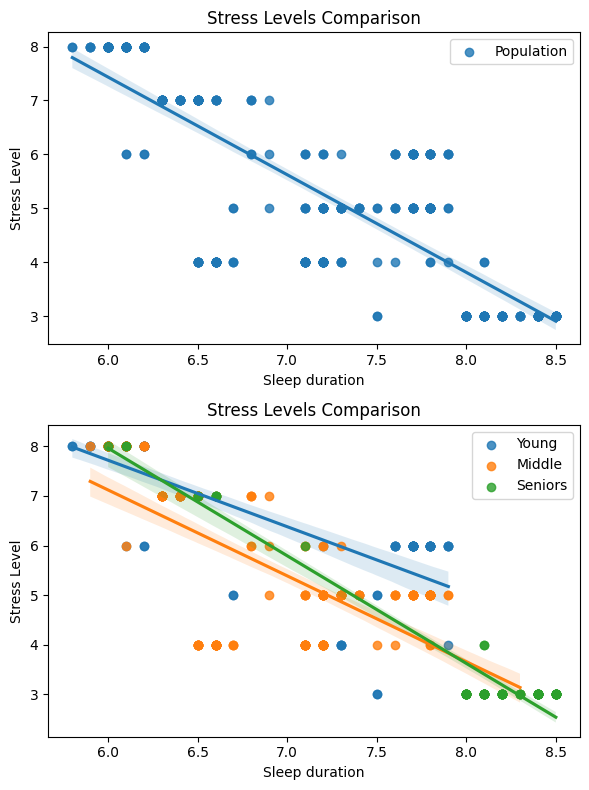

In [ ]:
# Let's divide respondents based on age groups & see sleep_duration and stress level trend.

young = df[(df['age'] >= 20) & (df['age'] <= 35)]
middle_age = df[(df['age'] > 35) & (df['age'] <= 50)]
seniors = df[(df['age'] > 50)]

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

sns.regplot(data=df, x='sleep_dur', y='stress', ax=axs[0], label='Population')
axs[0].set_xlabel('Sleep duration')
axs[0].set_ylabel('Stress Level')
axs[0].set_title('Stress Levels Comparison')
axs[0].legend()

sns.regplot(data=young, x='sleep_dur', y='stress', ax=axs[1], label='Young')
sns.regplot(data=middle_age, x='sleep_dur', y='stress', ax=axs[1], label='Middle')
sns.regplot(data=seniors, x='sleep_dur', y='stress', ax=axs[1], label='Seniors')

axs[1].set_xlabel('Sleep duration')
axs[1].set_ylabel('Stress Level')
axs[1].set_title('Stress Levels Comparison')
axs[1].legend()

plt.tight_layout()
plt.show()


**Absence of Trend reversal: What does it suggest ?**

## Visualization 8: Violin plots


<Axes: xlabel='stress', ylabel='sleep_dur'>

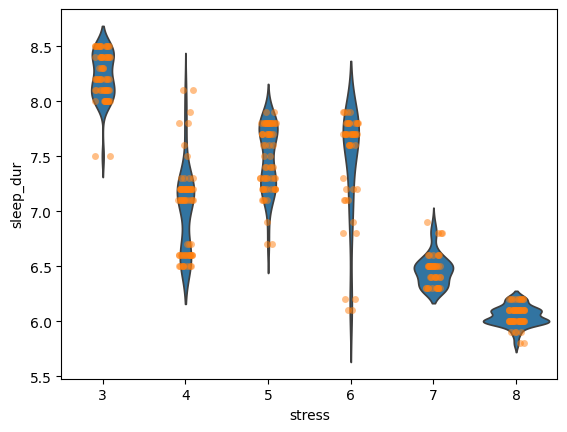

In [ ]:
sns.violinplot(data=df, x="stress", y="sleep_dur", inner=None)
sns.stripplot(data=df, x="stress", y="sleep_dur", alpha=0.5)


> We have already shown this plot as a box plot. Which of these two graphs is redundant & why ?


# Visualization 9: 3D plots

> Based on this visualization what are the most stressed occupation clusters ?

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    df,
    x='age',            # X-axis
    y='stress',         # Y-axis
    z='sleep_dur',      # Z-axis
    color='phys_act',   # optional 4th variable (color intensity)
    size='stress',      # optional: marker size by stress
    hover_name='occupation',   # show job title when hovering
    title='3D Visualization: Age, Stress, and Sleep Duration'
)

fig.update_traces(marker=dict(opacity=0.8))
fig.update_layout(scene=dict(
    xaxis_title='Age',
    yaxis_title='Stress Level',
    zaxis_title='Sleep Duration'
))

fig.show()


## Conclusions

1. **Stress vs age:** Stress is high in the 20s, spreads out in the 30s, often rises in the 40s, and drops after ~50 (the decline is clearer for women).
2. **Gender & sleep:** Women report **better sleep quality** and, correspondingly, slightly **lower stress**; once you consider age and job, gender gaps are small.
3. **Occupation:** **Doctors, sales/sales-rep, and scientists** show higher stress; **teachers, accountants, engineers** are lower; **nurses** are split with a midlife peak then decline.
4. **Sleep & health:** Better/longer sleep is generally associated with **lower stress** and **lower blood pressure** across groups.
5. **Caution:** This is a small sample; we did **not** find a consistent Simpson’s paradox—faceting by age, job, or sleep disorder changes magnitudes more than direction.
